# Methods
* I find this Kernel from https://www.kaggle.com/obichkin/top10-solution-on-xgboost/versions

* the result is not like validation data because of the input data is too small
* I find this kernel https://www.kaggle.com/dlarionov/feature-engineering-xgboost is very hard to improve , this method create too much useless feature , and very easy to overfit


# Load the data

In [7]:
import os
os.listdir("./")

['items.csv',
 'test.csv.gz',
 '.ipynb_checkpoints',
 'sales_train.csv.gz',
 'Top10 solution on XGBoost.ipynb',
 'sample_submission.csv.gz',
 'shops.csv',
 'item_categories.csv']

In [8]:
import pandas as pd
import numpy as np
import gc
import itertools
from tqdm import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
DATA_FOLDER = './'
train     = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items     = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_cats = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops     = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
test      = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz'))
test['date_block_num'] = 34
groupby_cols = ['date_block_num', 'shop_id', 'item_id']

# Add some features

I did not extract too much information from text fields, just 2 features:
**city** (which is also encoded in **shop_id**),
and **meta_cat** (some meta category, higher level aggregation of a **category** field)

In [9]:
#category
cat = items[['item_id', 'item_category_id']].drop_duplicates()
cat.set_index(['item_id'], inplace=True)
cat = cat.item_category_id
train['cat'] = train.item_id.map(cat)

#meta_category   games, gifts, work, etc.
item_cats['meta_cat'] = item_cats.item_category_name.apply(lambda x: x.split(' ')[0])
item_cats['meta_cat'] = pd.Categorical(item_cats.meta_cat).codes
item_cats.set_index(['item_category_id'], inplace=True)
meta_cat = item_cats.meta_cat
train['meta_cat'] = train.cat.map(meta_cat)

#city
shops['city'] = shops.shop_name.apply(lambda x: str.replace(x, '!', '')).apply(lambda x: x.split(' ')[0])
shops['city'] = pd.Categorical(shops['city']).codes
city = shops.city
train['city'] = train.shop_id.map(city)

#year
year = pd.concat([train.date_block_num, train.date.apply(lambda x: int(x.split('.')[2]))], axis=1).drop_duplicates()
year.set_index(['date_block_num'], inplace=True)
year = year.date.append( pd.Series([2015], index=[34]) )

#month
month = pd.concat([train.date_block_num, train.date.apply(lambda x: int(x.split('.')[1]))], axis=1).drop_duplicates()
month.set_index(['date_block_num'], inplace=True)
month = month.date.append( pd.Series([11], index=[34]) )

In [10]:
all_shops_items = []

for block_num in train['date_block_num'].unique():
    unique_shops = train[ train['date_block_num']==block_num ]['shop_id'].unique()
    unique_items = train[ train['date_block_num']==block_num ]['item_id'].unique()
    all_shops_items.append( np.array( list( itertools.product([block_num], unique_shops, unique_items) ), dtype='int32' ) )

df = pd.DataFrame( np.vstack( all_shops_items ), columns=groupby_cols , dtype='int32')
df = df.append(test )

df['ID'] = df.ID.fillna(-1).astype('int32')

df['year'] = df.date_block_num.map(year)
df['month'] = df.date_block_num.map(month)
df['cat'] = df.item_id.map(cat)
df['meta_cat'] = df.cat.map(meta_cat)
df['city'] = df.shop_id.map(city)
train['cat'] = train.item_id.map(cat)

/home/ginko/.local/lib/python3.5/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [11]:
df.sample(5)

,ID,date_block_num,item_id,shop_id,year,month,cat,meta_cat,city
4527089,-1,12,11464,58,2014,1,40,7,29
2560201,-1,6,15715,46,2013,7,37,7,21
8526764,-1,24,15063,26,2015,1,30,5,13
8366176,-1,23,13133,5,2014,12,57,9,3
4232658,-1,11,16626,17,2013,12,37,7,11


# Some plots.
Overall trend - the sales are decreasing. Peaks on December. date_block_num's [0: 12] contain quite a lot of training data, it is useful to keep them in the training set.

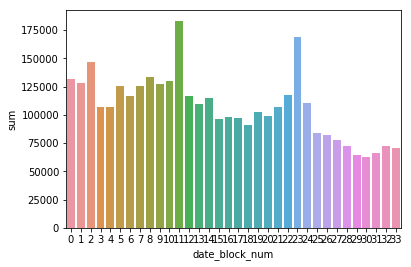

In [12]:
gb = train.groupby(by=['date_block_num'], as_index=False).agg({ 'item_cnt_day': ['sum']})
sns.barplot(x=gb['date_block_num'], y=gb['item_cnt_day']['sum'])

Most of the target values are just Zeros.

# Calculating different aggregations

In [15]:
gb = train.groupby(by=groupby_cols, as_index=False).agg({ 'item_cnt_day': ['sum']})
gb.columns = [val[0] if val[-1]=='' else '_'.join(val) for val in gb.columns.values]
gb.rename(columns={'item_cnt_day_sum':'target'}, inplace=True)
df = pd.merge(df, gb, how='left', on=groupby_cols)

gb = train.groupby(by=['date_block_num', 'item_id'], as_index=False).agg({'item_cnt_day':['sum']})
gb.columns = [val[0] if val[-1]=='' else '_'.join(val) for val in gb.columns.values]
gb.rename(columns={'item_cnt_day_sum':'target_item'}, inplace=True)
df = pd.merge(df, gb, how='left', on=['date_block_num', 'item_id'])

gb = train.groupby(by=['date_block_num', 'shop_id'], as_index=False).agg({'item_cnt_day':['sum']})
gb.columns = [val[0] if val[-1]=='' else '_'.join(val) for val in gb.columns.values]
gb.rename(columns={'item_cnt_day_sum':'target_shop'}, inplace=True)
df = pd.merge(df, gb, how='left', on=['date_block_num', 'shop_id'])

gb = train.groupby( by=['date_block_num', 'cat'], as_index=False).agg({ 'item_cnt_day': ['sum'] })
gb.columns = [val[0] if val[-1]=='' else '_'.join(val) for val in gb.columns.values]
gb.rename(columns={'item_cnt_day_sum':'target_cat'}, inplace=True)
df = pd.merge(df, gb, how='left', on=['date_block_num', 'cat'])

gb = train.groupby(by=['date_block_num', 'item_id'], as_index=False).agg({'item_price':['mean', 'max']})
gb.columns = [val[0] if val[-1]=='' else '_'.join(val) for val in gb.columns.values]
gb.rename(columns={'item_price_mean':'target_price_mean', 'item_price_max':'target_price_max'}, inplace=True)
df = pd.merge(df, gb, how='left', on=['date_block_num', 'item_id'])

# Clipping some outlier prices

In [16]:
df['target_price_mean'] = np.minimum(df['target_price_mean'], df['target_price_mean'].quantile(0.99))
df['target_price_max'] = np.minimum(df['target_price_max'], df['target_price_max'].quantile(0.99))

df.fillna(0, inplace=True)
df['target'] = df['target'].clip(0, 20)
df['target_zero'] = (df['target'] > 0).astype("int32")

/home/ginko/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in minimum
  """Entry point for launching an IPython kernel.
/home/ginko/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in minimum
  


# Mean Encodings

In [17]:
%%time
for enc_cols in [['shop_id', 'cat'], ['shop_id', 'item_id'], ['shop_id'], ['item_id']]:
    
    col = '_'.join(['enc', *enc_cols])
    col2 = '_'.join(['enc_max', *enc_cols])
    df[col] = np.nan
    df[col2] = np.nan
    
    print(col, col2)
    
    for d in tqdm_notebook(df.date_block_num.unique()):
        

        f1 = df.date_block_num < d
        f2 = df.date_block_num == d

        gb = df.loc[f1].groupby(enc_cols)[['target']].mean().reset_index()
        enc = df.loc[f2][enc_cols].merge(gb, on=enc_cols, how='left' )[['target']].copy()
        enc.set_index(df.loc[f2].index, inplace=True)
        df.loc[f2, col] = enc['target']
        
        gb = df.loc[f1].groupby(enc_cols)[['target']].max().reset_index()
        enc = df.loc[f2][enc_cols].merge(gb, on=enc_cols, how='left' )[['target']].copy()
        enc.set_index(df.loc[f2].index, inplace=True)
        df.loc[f2, col2] = enc['target']
        

enc_shop_id_cat enc_max_shop_id_cat



enc_shop_id_item_id enc_max_shop_id_item_id



enc_shop_id enc_max_shop_id



enc_item_id enc_max_item_id



CPU times: user 2min 3s, sys: 1min 15s, total: 3min 18s
Wall time: 3min 18s


In [18]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float32_cols = [c for c in df if df[c].dtype == "float64"]
    int32_cols = [c for c in df if df[c].dtype in ["int64"] ]
            
    # Downcast
    df[float32_cols] = df[float32_cols].astype(np.float32)
    df[int32_cols]   = df[int32_cols].astype(np.int32)
        
    return df

In [19]:
df.fillna(0, inplace=True)
df = downcast_dtypes(df)

# Historical values

In [20]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import os
import gc
from time import sleep

groupby_cols = ['date_block_num', 'shop_id', 'item_id']
shift_range = [1, 2, 3, 4, 5, 12]

In [21]:
%%time

shifted_columns = [c for c in df if 'target' in c]
print(shifted_columns)


for shift in tqdm_notebook(shift_range):
    
    
    shifted_data = df[groupby_cols + shifted_columns].copy()
    shifted_data['date_block_num'] = shifted_data['date_block_num'] + shift
    
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in shifted_columns else x
    shifted_data = shifted_data.rename(columns=foo)
    
    
    df = pd.merge(df, shifted_data, how='left', on=groupby_cols).fillna(0)
    df = downcast_dtypes(df)

    del shifted_data
    gc.collect()
    sleep(1)

['target', 'target_item', 'target_shop', 'target_cat', 'target_price_mean', 'target_price_max', 'target_zero']



CPU times: user 33 s, sys: 26.2 s, total: 59.2 s
Wall time: 1min 4s


# Features Interaction
A big breakthrough happened, when i encoded these interactions. Check it out.

In [22]:
df['target_trend_1_2'] = df['target_lag_1'] - df['target_lag_2']
df['target_predict_1_2'] = df['target_lag_1']*2 - df['target_lag_2']



In [23]:
df = downcast_dtypes(df)


In [24]:
df['target_trend_3_4'] = df['target_lag_1'] + df['target_lag_2'] - df['target_lag_3'] - df['target_lag_4']
df['target_predict_3_4'] = (df['target_lag_1'] + df['target_lag_2'])*2 - df['target_lag_3'] - df['target_lag_4']

In [25]:
df = downcast_dtypes(df)


In [26]:
df['target_item_trend_1_2'] = df['target_item_lag_1'] - df['target_item_lag_2']
df['target_item_trend_3_4'] = df['target_item_lag_1'] + df['target_item_lag_2'] - df['target_item_lag_3'] - df['target_item_lag_4']
df['target_shop_trend_1_2'] = df['target_shop_lag_1'] - df['target_shop_lag_2']
df['target_shop_trend_3_4'] = df['target_shop_lag_1'] + df['target_shop_lag_2'] - df['target_shop_lag_3'] - df['target_shop_lag_4']

In [34]:
df = downcast_dtypes(df)
df.to_pickle("df.pkl")

In [3]:
gc.collect()

11

# XGBoost part

In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_squared_error, log_loss, accuracy_score, roc_curve, roc_auc_score
import gc
import xgboost as xgb
from sklearn.model_selection import train_test_split
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [9]:
df = pd.read_pickle("df.pkl")

drop_columns = [c for c in df if c[-1] not in ['1', '2', '3', '4', '5', '6', '7', '8', '9', '0'] and c.startswith('target')]
drop_columns += ['ID']
features = df.columns.difference( drop_columns )

f0 = df.date_block_num < 34
f1 = df.date_block_num == 34
train, val = train_test_split(df[f0], test_size=0.05, stratify=df[f0]['target'])
test = df[f1]


In [10]:
Train = xgb.DMatrix( train[features], train['target'] )
Val = xgb.DMatrix( val[features], val['target'] )
Test = xgb.DMatrix( test[features])

/usr/local/lib/python3.5/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.5/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [11]:
del df
gc.collect()

35

For the hyperparameters optimization see the Hyperopt section below. Here are the parameters, which turned out to be optimal.

In [24]:
%%time

xgb_params = {'booster': 'gbtree',
          'eta': .1,
          'min_child_weight': 100,
          'max_depth': 6,
          'objective': 'reg:linear',
          'eval_metric': 'rmse',
          'silent': False,
          'nthread': 8,
          'tree_method': 'gpu_hist'}

model = xgb.train(xgb_params, Train, 1234, [(Train, 'Train'), (Val, 'Val')], early_stopping_rounds=10, verbose_eval=50 )

[0]	Train-rmse:1.18917	Val-rmse:1.18895
Multiple eval metrics have been passed: 'Val-rmse' will be used for early stopping.

Will train until Val-rmse hasn't improved in 10 rounds.
[50]	Train-rmse:0.891185	Val-rmse:0.892069
[100]	Train-rmse:0.874618	Val-rmse:0.8769
[150]	Train-rmse:0.863641	Val-rmse:0.866475
[200]	Train-rmse:0.85552	Val-rmse:0.858922
[250]	Train-rmse:0.848616	Val-rmse:0.852771
[300]	Train-rmse:0.842647	Val-rmse:0.847331
[350]	Train-rmse:0.836898	Val-rmse:0.842793
[400]	Train-rmse:0.831858	Val-rmse:0.838654
[450]	Train-rmse:0.828343	Val-rmse:0.835874
[500]	Train-rmse:0.825008	Val-rmse:0.833333
[550]	Train-rmse:0.821285	Val-rmse:0.830445
[600]	Train-rmse:0.818308	Val-rmse:0.828374
[650]	Train-rmse:0.814468	Val-rmse:0.825427
[700]	Train-rmse:0.811473	Val-rmse:0.823216
[750]	Train-rmse:0.807953	Val-rmse:0.820724
[800]	Train-rmse:0.805196	Val-rmse:0.818712
[850]	Train-rmse:0.803253	Val-rmse:0.817457
[900]	Train-rmse:0.801063	Val-rmse:0.815985
[950]	Train-rmse:0.799129	Val-r

In [25]:
test['item_cnt_month'] = model.predict(Test).clip(0, 20)
test[['ID', 'item_cnt_month']].sort_values('ID').to_csv('boost_pred-3.csv', index=False)

In [50]:
#pickle.dump(model, open("xgb.pickle", "wb"))

In [51]:
#model = pickle.load(open("xgb.pickle", "rb"))

**item_id**, **date_block_num** and **month** have quite a predictive power :)

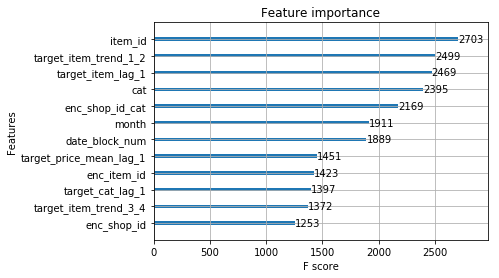

In [52]:
xgb.plot_importance(booster=model, max_num_features=24)